In [1]:
import sqlite3

from collections import Counter

import pandas as pd

import seaborn as sns
from matplotlib import pyplot as plt

In [2]:
S1 = "3 agree on A/B"
S2 = "2 agree on A/B, 1 dissenting"
S3 = "2 agree on A/B, 1 unsure"
S4 = "2 disagree on A/B, 1 unsure"
S5 = "2 unsure, 1 vote A/B"
S6 = "3 unsure"

SUMMARIES = {
    "AAA": S1,
    "BBB": S1,
    "AAB": S2,
    "ABB": S2,
    "AAU": S3,
    "BBU": S3,
    "ABU": S4,
    "AUU": S5,
    "BUU": S5,
    "UUU": S6,
}

CU = "Usable"
CN = "Not Usable"

CATEGORIES = {
    S1: CU,
    S2: CN,
    S3: CU,
    S4: CN,
    S5: CN,
    S6: CN
}

def to_vote_string(votes: Counter[str]):
    if votes.total() != 3:
        raise RuntimeError()
    if not (set(votes.keys()) <= {"A", "B", "U"}):
        raise RuntimeError()
    return "".join(sorted(votes.elements()))

In [3]:
sql = """
    SELECT
        I.id AS pair_id,
        S.name AS sequence_name,
        PA.name AS a_project,
        FA.filename AS a_name,
        FA.content AS a_content,
        PB.name AS b_project,
        FB.filename AS b_name,
        FB.content AS b_content,
        U.username,
        R.value
    FROM fileranker_response R
    JOIN auth_user U ON U.id = R.user_id
    JOIN fileranker_sequenceitem I ON I.id = R.item_id
    JOIN fileranker_sequence S ON S.id = I.sequence_id
    JOIN fileranker_file FA ON FA.id = I.file_a_id
    JOIN fileranker_file FB ON FB.id = I.file_b_id
    JOIN fileranker_project PA ON PA.id = FA.project_id
    JOIN fileranker_project PB ON PB.id = FB.project_id
    WHERE S.name = 'survey_loc_adjusted'
    ORDER BY S.name, I.position, U.id
"""

res_df = pd.read_sql(sql=sql, con=sqlite3.connect("results2.sqlite3"))
res_df = res_df[~(res_df["username"] == "admin")]
res_df.insert(3, "a_loc", [len(c.split("\n")) for c in res_df["a_content"]])
res_df.insert(5, "b_loc", [len(c.split("\n")) for c in res_df["b_content"]])
res_df = res_df.drop(["a_content", "b_content"], axis=1)
res_df

,pair_id,sequence_name,a_project,a_loc,a_name,b_loc,b_project,b_name,username,value
1,21038,survey_loc_adjusted,survey3,141,src/SurveyMenu.java,139,survey6,src/Question/ValidDateQuestion.java,chipmunk,A
2,21038,survey_loc_adjusted,survey3,141,src/SurveyMenu.java,139,survey6,src/Question/ValidDateQuestion.java,jackal,U
3,21038,survey_loc_adjusted,survey3,141,src/SurveyMenu.java,139,survey6,src/Question/ValidDateQuestion.java,wildcat,U
5,21039,survey_loc_adjusted,survey5,17,src/main/java/Essay.java,19,survey6,src/Import/Import.java,chipmunk,A
6,21039,survey_loc_adjusted,survey5,17,src/main/java/Essay.java,19,survey6,src/Import/Import.java,jackal,U
...,...,...,...,...,...,...,...,...,...,...
166,21087,survey_loc_adjusted,survey2,20,src/question/TrueFalseQuestion.java,19,survey6,src/Import/Import.java,chipmunk,A
167,21087,survey_loc_adjusted,survey2,20,src/question/TrueFalseQuestion.java,19,survey6,src/Import/Import.java,jackal,U
168,21087,survey_loc_adjusted,survey2,20,src/question/TrueFalseQuestion.java,19,survey6,src/Import/Import.java,wildcat,U
169,21088,survey_loc_adjusted,survey6,207,src/Question/CheckBoxQuestion.java,206,survey6,src/Question/MultipleChoiceQuestion.java,chipmunk,B


In [4]:
res_df.to_csv("reports/votes_raw2.csv")

In [5]:
vote_strings = []
consensus_rows = []
groups = res_df.groupby(["pair_id", "a_project", "a_name", "b_project", "b_name"])

for (pair_id, a_proj, a_name, b_proj, b_name), group_df in groups:
    votes = Counter(group_df["value"])
    if votes.total() != 3:
        continue
    vote_string = to_vote_string(votes)
    vote_strings.append(vote_string)
    if CATEGORIES[SUMMARIES[vote_string]] != CU:
        continue
    votes["U"] = 0
    if votes.most_common(1)[0][0] == "A":
        consensus_rows.append({
            "p_proj": a_proj,
            "p_name": a_name,
            "n_proj": b_proj,
            "n_name": b_name,
        })
    elif votes.most_common(1)[0][0] == "B":
        consensus_rows.append({
            "p_proj": b_proj,
            "p_name": b_name,
            "n_proj": a_proj,
            "n_name": a_name,
        })

consensus_df = pd.DataFrame.from_records(consensus_rows)
consensus_df

,p_proj,p_name,n_proj,n_name
0,survey2,src/ui/GUI.java,survey3,src/SurveyFormPanel.java
1,survey6,src/Import/SerializerImport.java,survey6,src/Survey/Survey.java
2,survey2,src/ui/GUI.java,survey6,src/Question/LinearScaleQuestion.java
3,survey1,src/com/surveysystem/util/Output.java,survey5,src/main/java/TestMenu.java
4,survey3,src/MainMenu.java,survey5,src/main/java/QuestionWithOptions.java
5,survey6,src/Menu/Menu.java,survey6,src/Menu/MenuOptions/DisplayOption.java
6,survey5,src/main/java/ReadableJSONExportStrategy.java,survey5,src/main/java/Date.java
7,survey6,src/Export/Export.java,survey1,src/com/surveysystem/question/QuestionCreator....
8,survey6,src/OutputHandler/OutputHandlerFactory.java,survey6,src/Menu/MenuOptions/TabulateOption.java
9,survey6,src/InputHandler/InputHandlerFactory.java,survey5,src/main/java/Date.java


<Axes: xlabel='count'>

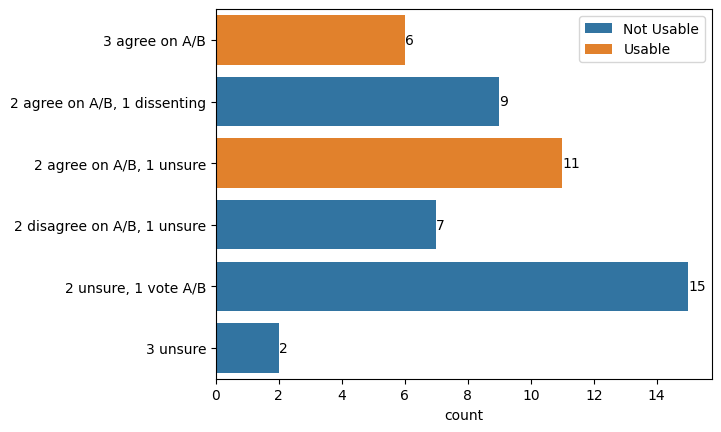

In [6]:
summaries = [SUMMARIES[v] for v in vote_strings]
categories = [CATEGORIES[s] for s in summaries]
ax = sns.countplot(y=summaries, hue=categories, order=[S1, S2, S3, S4, S5, S6])
for container in ax.containers:
    ax.bar_label(container)
ax

In [7]:
def to_team_id(db_name: str) -> int:
    return int(db_name.split("/")[-1].split("_")[0][-1])

lcom_df = pd.read_excel("report_survey2.xlsx")
lcom_df.insert(0, "project", [f"survey{to_team_id(d)}" for d in lcom_df["DB"]])
lcom_df = lcom_df.drop(["DB", "Name", "Kind"], axis=1)

def get_metric(project, filename, metric_name):
    df = lcom_df[(lcom_df["project"] == project) & (lcom_df["Filename"] == filename)]
    if len(df) != 1:
        raise RuntimeError
    return df.iloc[0][metric_name]
    
lcom_df

,project,Filename,LOC,Entities,Fields,Methods,LCOM1,LCOM2,LCOM3,MSC_avg,MSC_max,MSC_sum,MSC_sumsq,MSC_avg_s,MSC_max_s,MSC_sum_s,MSC_sumsq_s,MSC_LCOM1,MSC_sum_pairwise
0,survey1,src/YamlLoader.java,28,2,1,1,0,0.000000,NaN,1.467331,1.467336,2.934662,8.612243,0.733668,0.733668,1.467336,8.612243,0.000000,2.934668
1,survey1,src/com/surveysystem/form/Survey.java,45,10,3,7,15,0.714286,0.833333,2.370305,3.228553,23.703049,561.834518,0.814227,1.570814,8.142267,561.834518,3.260697,154.201249
2,survey1,src/com/surveysystem/io/CSVInput.java,33,4,0,4,6,NaN,NaN,2.256124,2.691698,9.024496,81.441529,0.000000,0.000000,0.000000,81.441529,1.290615,22.114249
3,survey1,src/com/surveysystem/io/CSVOutput.java,70,3,0,3,3,NaN,NaN,2.255224,2.541165,6.765673,45.774333,0.000000,0.000000,0.000000,45.774333,0.616047,11.721219
4,survey1,src/com/surveysystem/io/InputStrategy.java,18,3,0,3,3,NaN,NaN,2.068788,2.373027,6.206363,38.518938,0.000000,0.000000,0.000000,38.518938,0.660521,10.741716
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
180,survey7,src/main/java/TakenSurvey.java,22,4,1,3,3,0.666667,1.000000,2.278257,2.523849,9.113028,83.047272,0.346291,0.692582,1.385164,83.047272,0.660444,22.274244
181,survey7,src/main/java/TestPanel.java,116,3,2,1,0,0.000000,NaN,2.256038,2.543164,6.768114,45.807368,1.696308,2.268129,5.088923,45.807368,0.000000,11.721605
182,survey7,src/main/java/TestResponse.java,54,15,6,9,33,0.870370,0.979167,2.728239,3.432583,40.923588,1674.740038,0.969813,2.850312,14.547188,1674.740038,7.210974,411.043427
183,survey7,src/main/java/TrueFalseQuestion.java,37,7,2,5,10,1.000000,1.250000,2.586631,3.204678,18.106419,327.842395,0.000000,0.000000,0.000000,327.842395,2.290115,82.870857


In [8]:
def insert_metric(df, metric_name):
    df[f"p_{metric_name}"] = [get_metric(r["p_proj"], r["p_name"], metric_name) for _, r in df.iterrows()]
    df[f"n_{metric_name}"] = [get_metric(r["n_proj"], r["n_name"], metric_name) for _, r in df.iterrows()]


def get_correct(df, metric_name) -> set[int]:
    return set(df[df[f"p_{metric_name}"] < df[f"n_{metric_name}"]].index)

In [9]:
metric_names = [
    "LOC",
    "Entities",
    "LCOM1",
    "LCOM2",
    "LCOM3",
    "MSC_avg",
    "MSC_max",
    "MSC_sum",
    "MSC_sumsq",
    "MSC_avg_s",
    "MSC_max_s",
    "MSC_sum_s",
    "MSC_sumsq_s",
    "MSC_LCOM1",
    "MSC_sum_pairwise",
]

In [10]:
for metric_name in metric_names:
    insert_metric(consensus_df, metric_name)

In [11]:
metric_rows = []

for metric_name in metric_names:
    n_correct = len(get_correct(consensus_df, metric_name))
    n = len(consensus_df)
    acc = n_correct / len(consensus_df)
    metric_rows.append({
        "metric_name": metric_name,
        "n_correct": n_correct,
        "total": len(consensus_df),
        "accuracy": acc,
        # "min_moe_accuracy": acc - (0.20 * acc),
        # "max_moe_accuracy": acc + (0.20 * acc),
    })

metric_df = pd.DataFrame.from_records(metric_rows, index="metric_name")
metric_df

,n_correct,total,accuracy
metric_name,,,
LOC,9,17,0.529412
Entities,12,17,0.705882
LCOM1,12,17,0.705882
LCOM2,6,17,0.352941
LCOM3,5,17,0.294118
MSC_avg,12,17,0.705882
MSC_max,11,17,0.647059
MSC_sum,13,17,0.764706
MSC_sumsq,13,17,0.764706


In [14]:
overlap_rows = []

for i in range(len(metric_names)):
    i_name = metric_names[i]
    i_set = get_correct(consensus_df, i_name)
    for j in range(len(metric_names)):
        j_name = metric_names[j]
        j_set = get_correct(consensus_df, j_name)
        inter = len(i_set & j_set)
        union = len(i_set | j_set)
        overlap_rows.append({
            "i_name": i_name,
            "j_name": j_name,
            "intersection": inter,
            "union": union,
            "jaccard": inter / union,
        })
        # print(f"{i_name} vs {j_name}: {inter} / {union} = {inter / union:.2%}")

df = pd.DataFrame.from_records(overlap_rows)
df

,i_name,j_name,intersection,union,jaccard
0,LOC,LOC,9,9,1.000000
1,LOC,Entities,6,15,0.400000
2,LOC,LCOM1,6,15,0.400000
3,LOC,LCOM2,2,13,0.153846
4,LOC,LCOM3,2,12,0.166667
...,...,...,...,...,...
220,MSC_sum_pairwise,MSC_max_s,11,14,0.785714
221,MSC_sum_pairwise,MSC_sum_s,11,14,0.785714
222,MSC_sum_pairwise,MSC_sumsq_s,12,13,0.923077
223,MSC_sum_pairwise,MSC_LCOM1,10,14,0.714286
